# Data Analysis: Raw and Processed Datasets

This notebook provides comprehensive exploratory data analysis (EDA) for:
1. **Raw Dataset**: Initial survey data before preprocessing
2. **Processed Dataset**: Cleaned and encoded data ready for modeling

## Analysis includes:
- Data shape and structure
- Missing value analysis
- Target variable distribution
- Categorical feature distributions
- Class imbalance checks
- Train/test split validation
- Feature correlations


In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set paths
RAW_DATA = Path("../../data/raw/stack-overflow-developer-survey-2025-2/survey_results_public.csv")
CLEAN_DATA = Path("../../data/interim/so_2025_clean.csv")
PROCESSED_DATA = Path("../../data/processed/so_2025_model_ready.parquet")
TRAIN_DATA = Path("../../data/processed/so_2025_train.parquet")
TEST_DATA = Path("../../data/processed/so_2025_test.parquet")

print("Imports successful!")


Imports successful!


# Part 1: Raw Dataset Analysis


In [2]:
# Load raw dataset (only relevant columns)
USE_COLUMNS = [
    "Country",
    "EdLevel",
    "YearsCode",
    "Employment",
    "DevType",
    "ConvertedCompYearly",
    "RemoteWork",
    "Currency",
]

df_raw = pd.read_csv(RAW_DATA, usecols=USE_COLUMNS, na_values=["NA", "Other (please specify):"])

print(f"Raw Dataset Shape: {df_raw.shape}")
print(f"\nColumns: {list(df_raw.columns)}")
print(f"\nData Types:")
print(df_raw.dtypes)
df_raw.head()


Raw Dataset Shape: (49123, 8)

Columns: ['EdLevel', 'Employment', 'YearsCode', 'DevType', 'RemoteWork', 'Country', 'Currency', 'ConvertedCompYearly']

Data Types:
EdLevel                 object
Employment              object
YearsCode              float64
DevType                 object
RemoteWork              object
Country                 object
Currency                object
ConvertedCompYearly    float64
dtype: object


,EdLevel,Employment,YearsCode,DevType,RemoteWork,Country,Currency,ConvertedCompYearly
0,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed,14.0,"Developer, mobile",Remote,Ukraine,EUR European Euro,61256.0
1,"Associate degree (A.A., A.S., etc.)",Employed,10.0,"Developer, back-end","Hybrid (some in-person, leans heavy to flexibi...",Netherlands,EUR European Euro,104413.0
2,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Independent contractor, freelancer, or self-em...",12.0,"Developer, front-end",NaN,Ukraine,UAH Ukrainian hryvnia,53061.0
3,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed,5.0,"Developer, back-end",Remote,Ukraine,EUR European Euro,36197.0
4,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...",22.0,Engineering manager,NaN,Ukraine,USD United States dollar,60000.0


Missing Values in Raw Dataset:
                     Missing Count  Missing %
ConvertedCompYearly          25195      51.29
RemoteWork                   15376      31.30
Country                      13721      27.93
Currency                     13721      27.93
DevType                       7310      14.88
YearsCode                     6123      12.46
EdLevel                       1737       3.54
Employment                     846       1.72


<Figure size 1000x600 with 0 Axes>

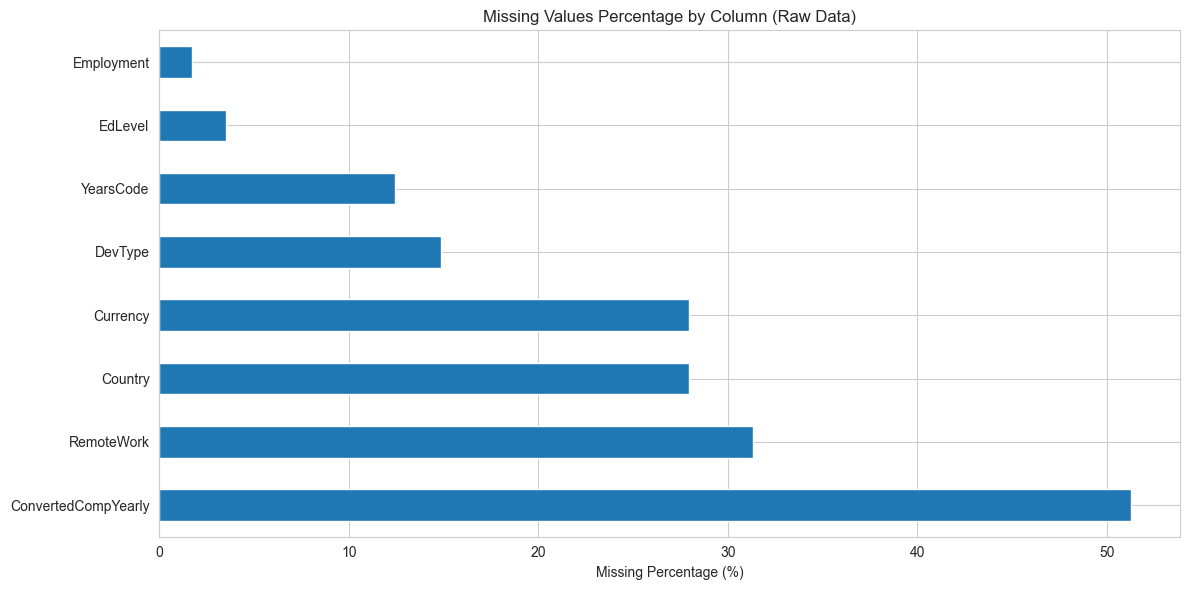

In [3]:
# Missing values analysis
missing = df_raw.isna().sum()
missing_pct = (missing / len(df_raw) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
}).sort_values('Missing %', ascending=False)

print("Missing Values in Raw Dataset:")
print(missing_df[missing_df['Missing Count'] > 0])

# Visualize missing values
if missing_df['Missing Count'].sum() > 0:
    plt.figure(figsize=(10, 6))
    missing_df[missing_df['Missing Count'] > 0].plot(kind='barh', y='Missing %', legend=False)
    plt.title('Missing Values Percentage by Column (Raw Data)')
    plt.xlabel('Missing Percentage (%)')
    plt.tight_layout()
    plt.show()


Valid salary entries: 23,928 (48.7%)

Salary Statistics:
count    2.392800e+04
mean     1.017916e+05
std      4.619345e+05
min      1.000000e+00
25%      3.817100e+04
50%      7.538350e+04
75%      1.206302e+05
max      5.000000e+07
Name: ConvertedCompYearly, dtype: float64


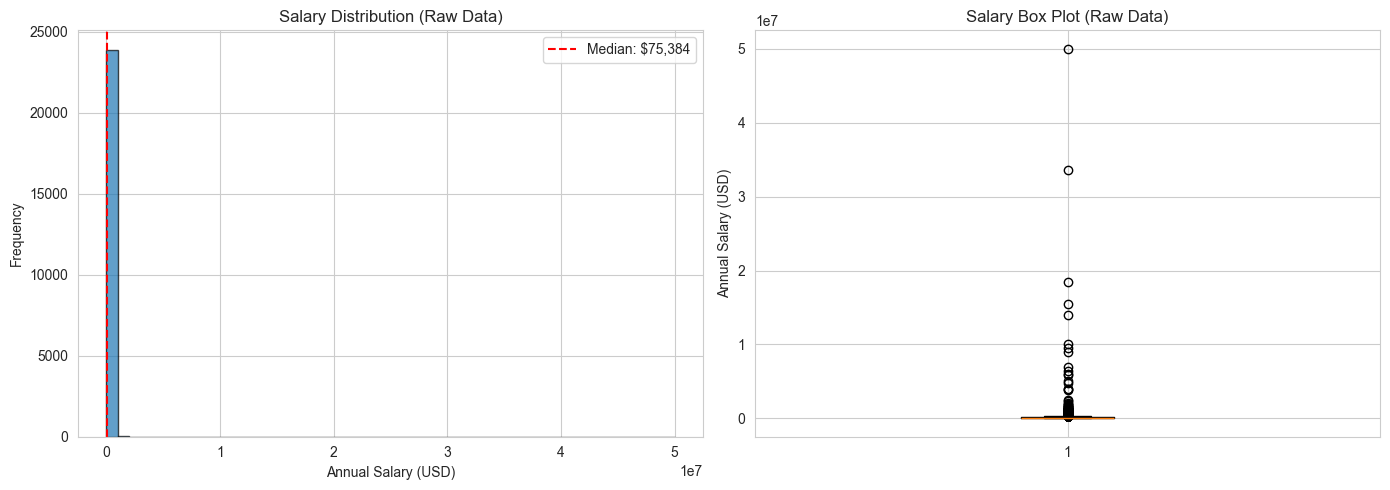


Outliers (IQR method): 1,061 (4.4%)


In [4]:
# Target variable analysis (salary)
salary_col = 'ConvertedCompYearly'
valid_salaries = df_raw[salary_col].dropna()

print(f"Valid salary entries: {len(valid_salaries):,} ({len(valid_salaries)/len(df_raw)*100:.1f}%)")
print(f"\nSalary Statistics:")
print(valid_salaries.describe())

# Distribution plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(valid_salaries, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Salary Distribution (Raw Data)')
axes[0].set_xlabel('Annual Salary (USD)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(valid_salaries.median(), color='red', linestyle='--', label=f'Median: ${valid_salaries.median():,.0f}')
axes[0].legend()

# Box plot
axes[1].boxplot(valid_salaries, vert=True)
axes[1].set_title('Salary Box Plot (Raw Data)')
axes[1].set_ylabel('Annual Salary (USD)')

plt.tight_layout()
plt.show()

# Outliers
Q1 = valid_salaries.quantile(0.25)
Q3 = valid_salaries.quantile(0.75)
IQR = Q3 - Q1
outliers = valid_salaries[(valid_salaries < Q1 - 1.5*IQR) | (valid_salaries > Q3 + 1.5*IQR)]
print(f"\nOutliers (IQR method): {len(outliers):,} ({len(outliers)/len(valid_salaries)*100:.1f}%)")



Employment Distribution:
Employment
Employed                                                33709
Independent contractor, freelancer, or self-employed     6700
Student                                                  4420
Not employed                                             2222
Retired                                                   708
I prefer not to say                                       518
Name: count, dtype: int64
Unique values: 6


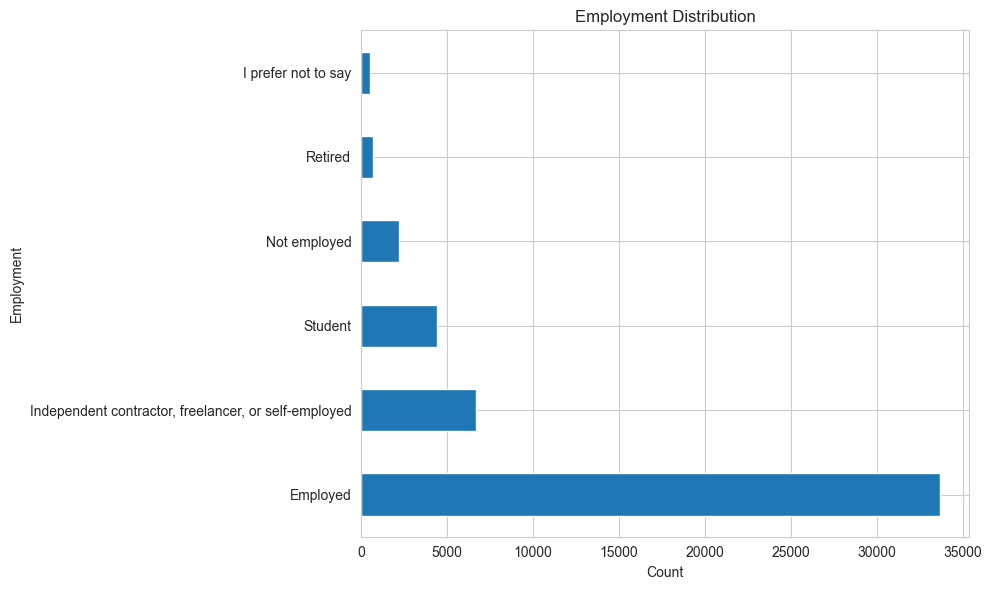


Country Distribution:
Country
United States of America                                7226
Germany                                                 3022
India                                                   2542
United Kingdom of Great Britain and Northern Ireland    2038
France                                                  1409
Canada                                                  1303
Ukraine                                                  964
Poland                                                   887
Netherlands                                              867
Italy                                                    834
Name: count, dtype: int64
Unique values: 177


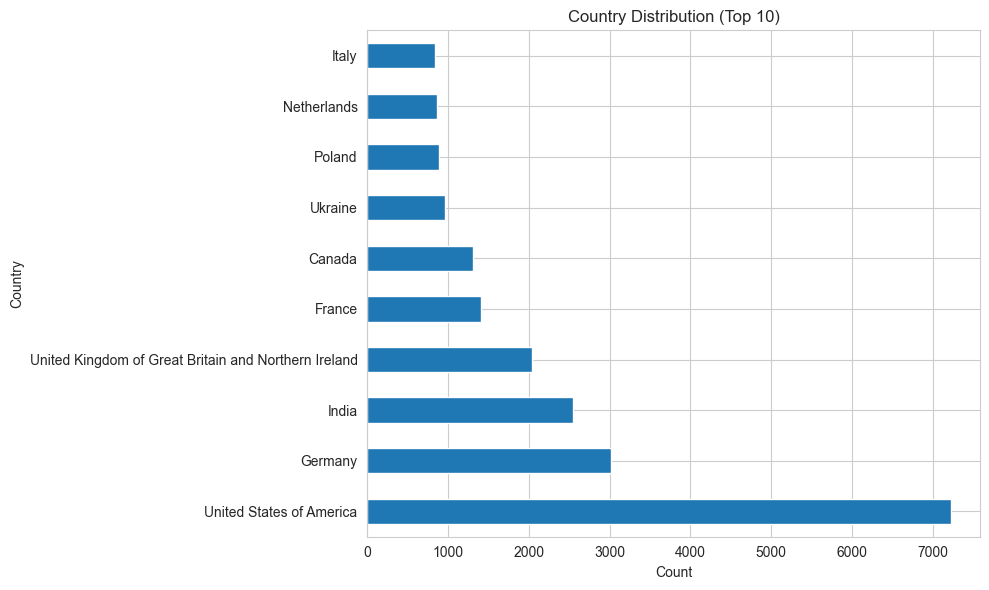


EdLevel Distribution:
EdLevel
Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          20247
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                       12575
Some college/university study without earning a degree                                 6175
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)     3627
Professional degree (JD, MD, Ph.D, Ed.D, etc.)                                         2620
Associate degree (A.A., A.S., etc.)                                                    1560
Primary/elementary school                                                               582
Name: count, dtype: int64
Unique values: 7


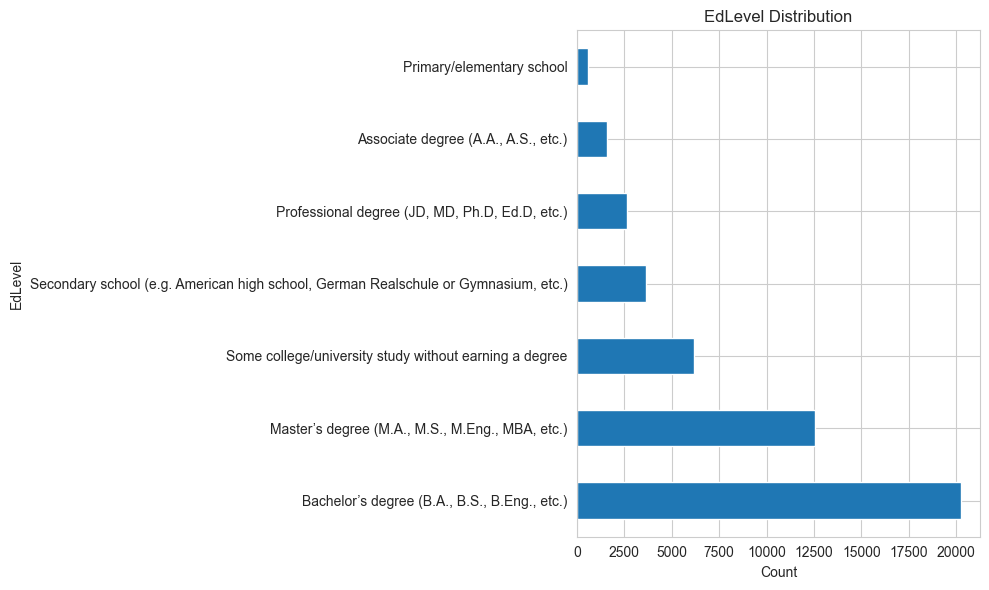


RemoteWork Distribution:
RemoteWork
Remote                                                                          10924
Hybrid (some remote, leans heavy to in-person)                                   6728
In-person                                                                        6034
Hybrid (some in-person, leans heavy to flexibility)                              5824
Your choice (very flexible, you can come in when you want or just as needed)     4237
Name: count, dtype: int64
Unique values: 5


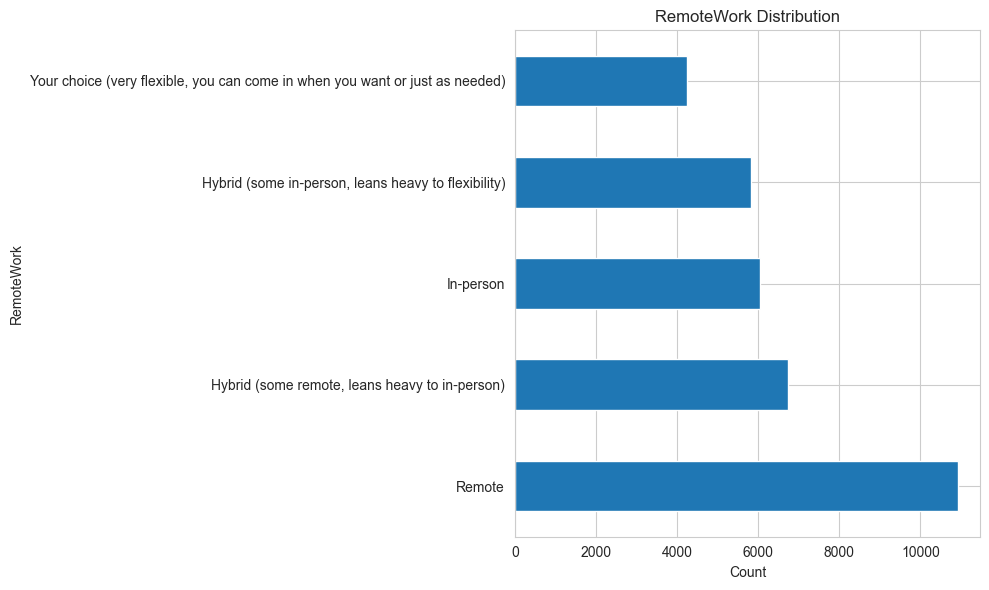

In [5]:
# Categorical feature distributions
categorical_cols = ['Employment', 'Country', 'EdLevel', 'RemoteWork']

for col in categorical_cols:
    if col in df_raw.columns:
        print(f"\n{col} Distribution:")
        value_counts = df_raw[col].value_counts()
        print(value_counts.head(10))
        print(f"Unique values: {df_raw[col].nunique()}")
        
        # Plot top 10
        if len(value_counts) > 10:
            top_10 = value_counts.head(10)
            plt.figure(figsize=(10, 6))
            top_10.plot(kind='barh')
            plt.title(f'{col} Distribution (Top 10)')
            plt.xlabel('Count')
            plt.tight_layout()
            plt.show()
        else:
            plt.figure(figsize=(10, 6))
            value_counts.plot(kind='barh')
            plt.title(f'{col} Distribution')
            plt.xlabel('Count')
            plt.tight_layout()
            plt.show()


# Part 2: Processed Dataset Analysis


In [6]:
# Load processed datasets
df_clean = pd.read_csv(CLEAN_DATA)
df_processed = pd.read_parquet(PROCESSED_DATA)
df_train = pd.read_parquet(TRAIN_DATA)
df_test = pd.read_parquet(TEST_DATA)

print("Processed Datasets Loaded:")
print(f"  Clean dataset: {df_clean.shape}")
print(f"  Processed dataset: {df_processed.shape}")
print(f"  Train dataset: {df_train.shape}")
print(f"  Test dataset: {df_test.shape}")

print(f"\nClean Dataset Columns:")
print(list(df_clean.columns))
df_clean.head()


Processed Datasets Loaded:
  Clean dataset: (20907, 8)
  Processed dataset: (20907, 194)
  Train dataset: (16725, 194)
  Test dataset: (4182, 194)

Clean Dataset Columns:
['CompYearlyUSD', 'Country', 'EdLevelSimplified', 'YearsCodeNum', 'Employment', 'DevTypePrimary', 'RemoteCategory', 'SalaryLog10']


,CompYearlyUSD,Country,EdLevelSimplified,YearsCodeNum,Employment,DevTypePrimary,RemoteCategory,SalaryLog10
0,61256.0,Ukraine,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",14.0,Employed,"Developer, mobile",Remote,4.787149
1,104413.0,Netherlands,Some college,10.0,Employed,"Developer, back-end",Hybrid-Flexible,5.018755
2,53061.0,Ukraine,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",12.0,"Independent contractor, freelancer, or self-em...","Developer, front-end",NaN,4.724775
3,36197.0,Ukraine,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5.0,Employed,"Developer, back-end",Remote,4.558673
4,60000.0,Ukraine,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",22.0,"Independent contractor, freelancer, or self-em...",Engineering manager,NaN,4.778151


In [7]:
# Check for missing values in processed data
print("Missing Values in Clean Dataset:")
missing_clean = df_clean.isna().sum()
print(missing_clean[missing_clean > 0] if missing_clean.sum() > 0 else "No missing values!")

print("\nMissing Values in Processed Dataset:")
missing_processed = df_processed.isna().sum()
print(missing_processed[missing_processed > 0] if missing_processed.sum() > 0 else "No missing values!")


Missing Values in Clean Dataset:
RemoteCategory    1810
dtype: int64

Missing Values in Processed Dataset:
No missing values!


Clean Dataset - Salary Statistics:
count     20907.000000
mean      95069.987086
std       75392.860126
min        1000.000000
25%       46118.500000
50%       80050.000000
75%      125000.000000
max      600000.000000
Name: CompYearlyUSD, dtype: float64


/var/folders/97/qhn67ff95n3brkkxszz9k2w40000gp/T/ipykernel_39076/3546532279.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(box_data, labels=['Train', 'Test'])


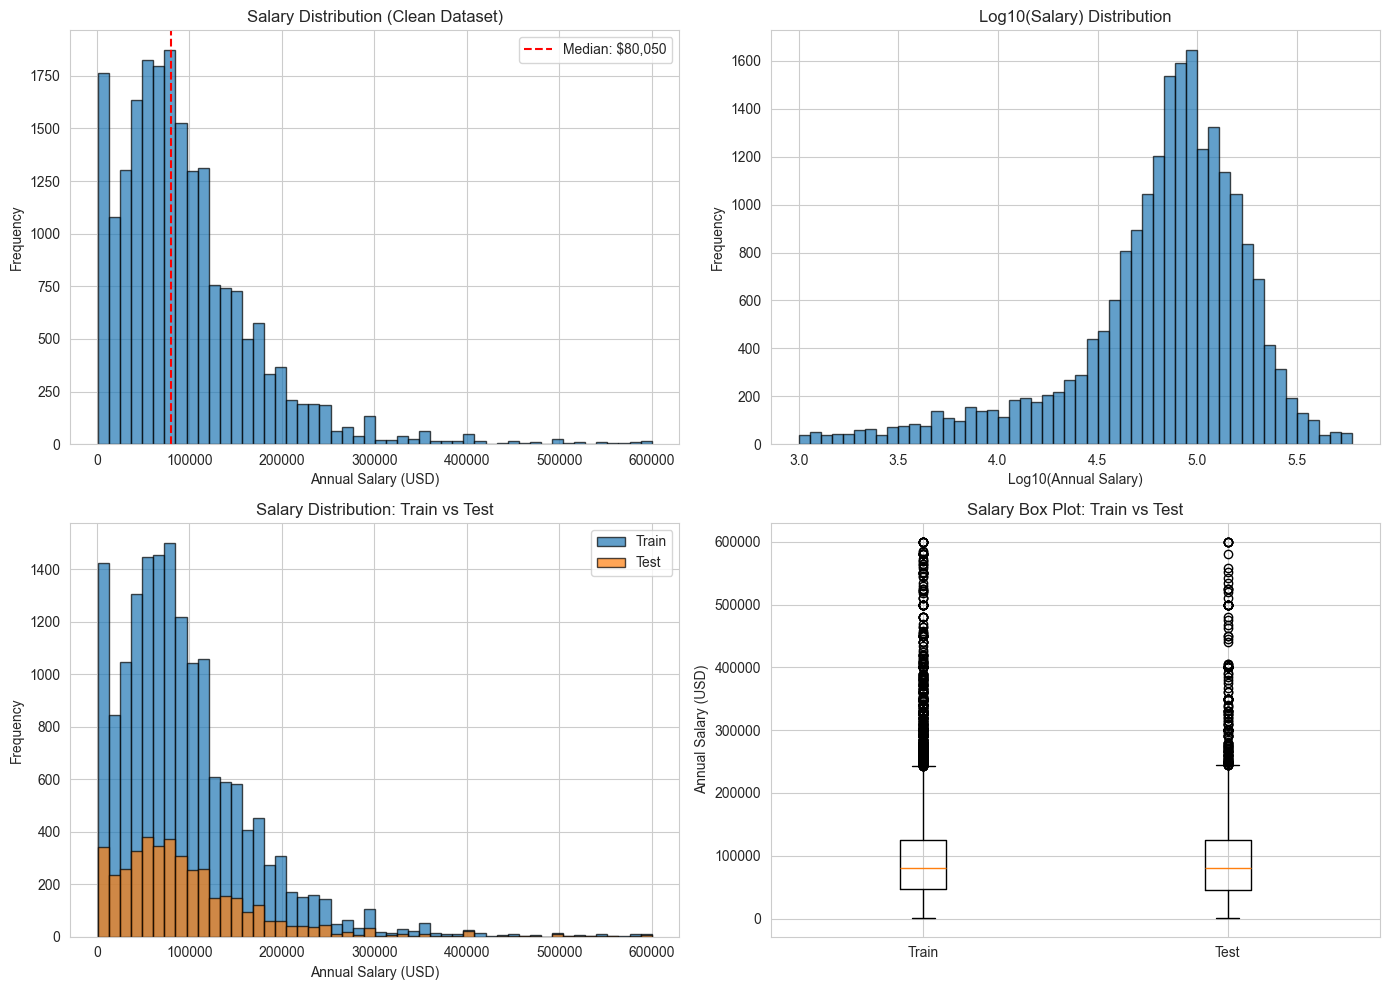

In [8]:
# Target variable analysis after preprocessing
target_col = 'CompYearlyUSD'

print("Clean Dataset - Salary Statistics:")
print(df_clean[target_col].describe())

# Distribution comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Clean dataset distribution
axes[0, 0].hist(df_clean[target_col], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Salary Distribution (Clean Dataset)')
axes[0, 0].set_xlabel('Annual Salary (USD)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df_clean[target_col].median(), color='red', linestyle='--', 
                   label=f'Median: ${df_clean[target_col].median():,.0f}')
axes[0, 0].legend()

# Log-transformed distribution
axes[0, 1].hist(df_clean['SalaryLog10'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Log10(Salary) Distribution')
axes[0, 1].set_xlabel('Log10(Annual Salary)')
axes[0, 1].set_ylabel('Frequency')

# Train/Test comparison
axes[1, 0].hist(df_train[target_col], bins=50, alpha=0.7, label='Train', edgecolor='black')
axes[1, 0].hist(df_test[target_col], bins=50, alpha=0.7, label='Test', edgecolor='black')
axes[1, 0].set_title('Salary Distribution: Train vs Test')
axes[1, 0].set_xlabel('Annual Salary (USD)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# Box plot comparison
box_data = [df_train[target_col], df_test[target_col]]
axes[1, 1].boxplot(box_data, labels=['Train', 'Test'])
axes[1, 1].set_title('Salary Box Plot: Train vs Test')
axes[1, 1].set_ylabel('Annual Salary (USD)')

plt.tight_layout()
plt.show()


In [9]:
# Train/Test split validation
print("Train/Test Split Statistics:")
print(f"\nTrain set: {len(df_train):,} samples ({len(df_train)/(len(df_train)+len(df_test))*100:.1f}%)")
print(f"Test set: {len(df_test):,} samples ({len(df_test)/(len(df_train)+len(df_test))*100:.1f}%)")

print("\nTarget Variable Statistics:")
print("\nTrain:")
print(df_train[target_col].describe())
print("\nTest:")
print(df_test[target_col].describe())

# Check if distributions are similar (stratified split validation)
from scipy import stats
ks_statistic, p_value = stats.ks_2samp(df_train[target_col], df_test[target_col])
print(f"\nKolmogorov-Smirnov Test (Train vs Test):")
print(f"  KS Statistic: {ks_statistic:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Interpretation: {'Distributions are similar' if p_value > 0.05 else 'Distributions differ significantly'}")


Train/Test Split Statistics:

Train set: 16,725 samples (80.0%)
Test set: 4,182 samples (20.0%)

Target Variable Statistics:

Train:
count     16725.000000
mean      94784.835635
std       74520.742118
min        1000.000000
25%       46381.000000
50%       80050.000000
75%      125000.000000
max      600000.000000
Name: CompYearlyUSD, dtype: float64

Test:
count      4182.000000
mean      96210.388331
std       78783.159233
min        1000.000000
25%       45888.250000
50%       80152.000000
75%      125341.750000
max      600000.000000
Name: CompYearlyUSD, dtype: float64

Kolmogorov-Smirnov Test (Train vs Test):
  KS Statistic: 0.0090
  p-value: 0.9462
  Interpretation: Distributions are similar


## Class Imbalance Analysis

For regression, we check for imbalance in:
1. Categorical features (Country, Education, DevType, etc.)
2. Salary distribution (binned for stratification)



Country Distribution:
                                                    Count  Percentage
Country                                                              
United States of America                             4581       21.91
Germany                                              1837        8.79
United Kingdom of Great Britain and Northern Ir...   1336        6.39
India                                                 937        4.48
France                                                919        4.40
...                                                   ...         ...
Qatar                                                   1        0.00
Haiti                                                   1        0.00
Libyan Arab Jamahiriya                                  1        0.00
Botswana                                                1        0.00
Guinea                                                  1        0.00

[156 rows x 2 columns]

Imbalance Metrics:
  Most common: United S

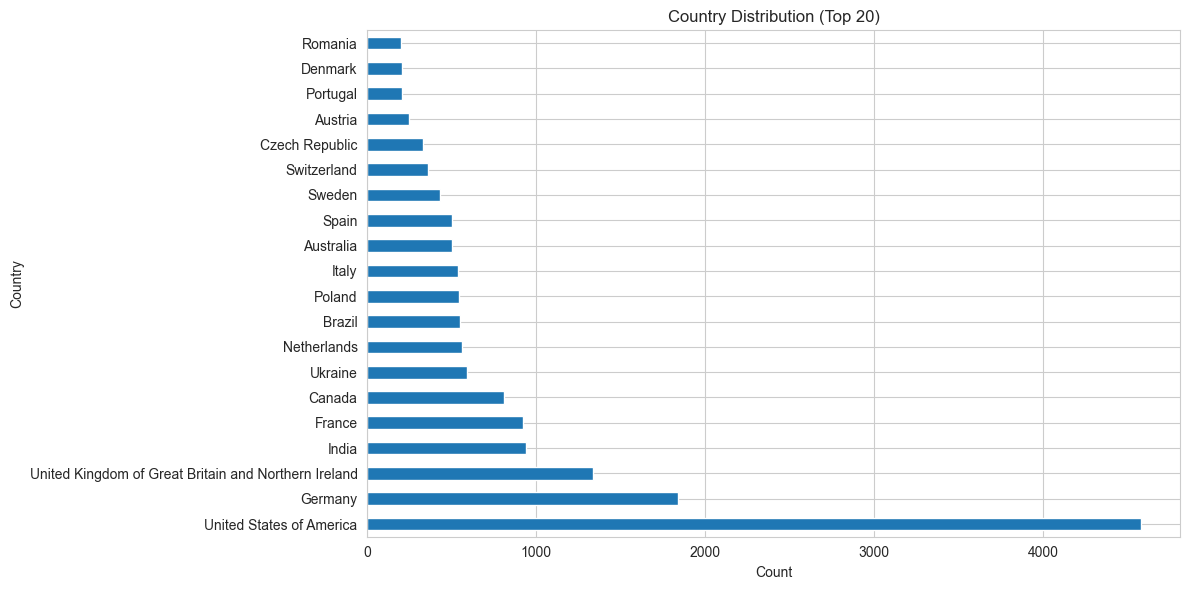


EdLevelSimplified Distribution:
                                                 Count  Percentage
EdLevelSimplified                                                 
Bachelor’s degree (B.A., B.S., B.Eng., etc.)      9359       44.76
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)   6242       29.86
Some college                                      4289       20.51
Less than secondary                               1017        4.86

Imbalance Metrics:
  Most common: Bachelor’s degree (B.A., B.S., B.Eng., etc.) (44.76%)
  Least common: Less than secondary (4.86%)
  Imbalance ratio: 9.21x
  ✓ Relatively balanced


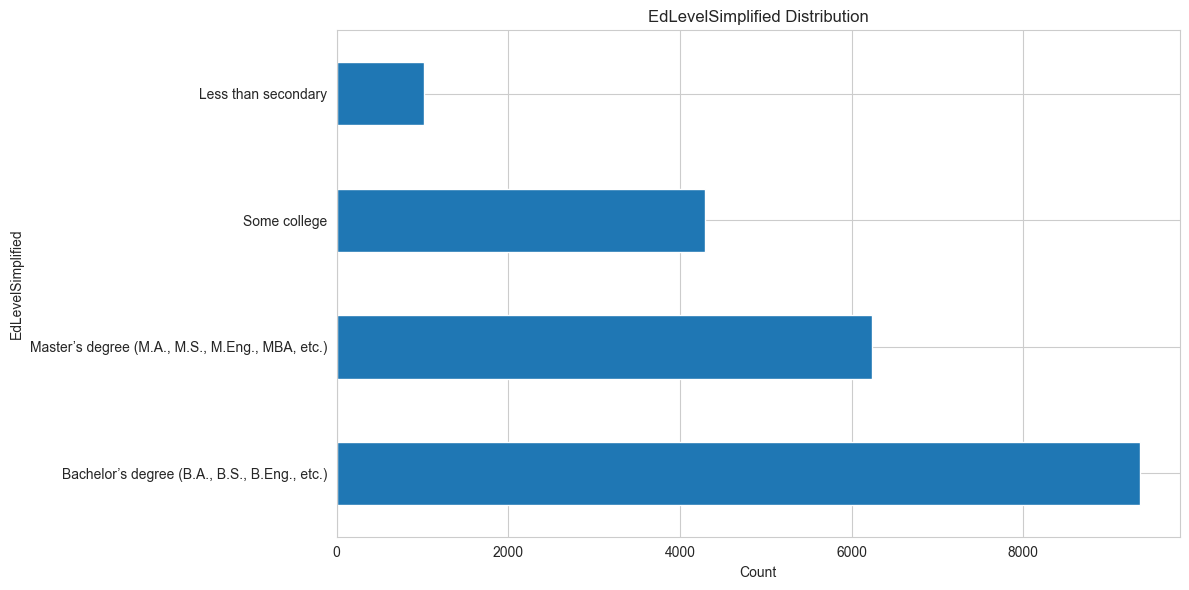


DevTypePrimary Distribution:
                                               Count  Percentage
DevTypePrimary                                                  
Developer, full-stack                           6904       33.02
Developer, back-end                             3667       17.54
Architect, software or solutions                1547        7.40
Developer, desktop or enterprise applications   1056        5.05
Developer, front-end                            1009        4.83
Developer, embedded applications or devices      721        3.45
Developer, mobile                                709        3.39
Engineering manager                              682        3.26
DevOps engineer or professional                  654        3.13
Data engineer                                    459        2.20
Academic researcher                              417        1.99
Data scientist                                   314        1.50
AI/ML engineer                                   314        

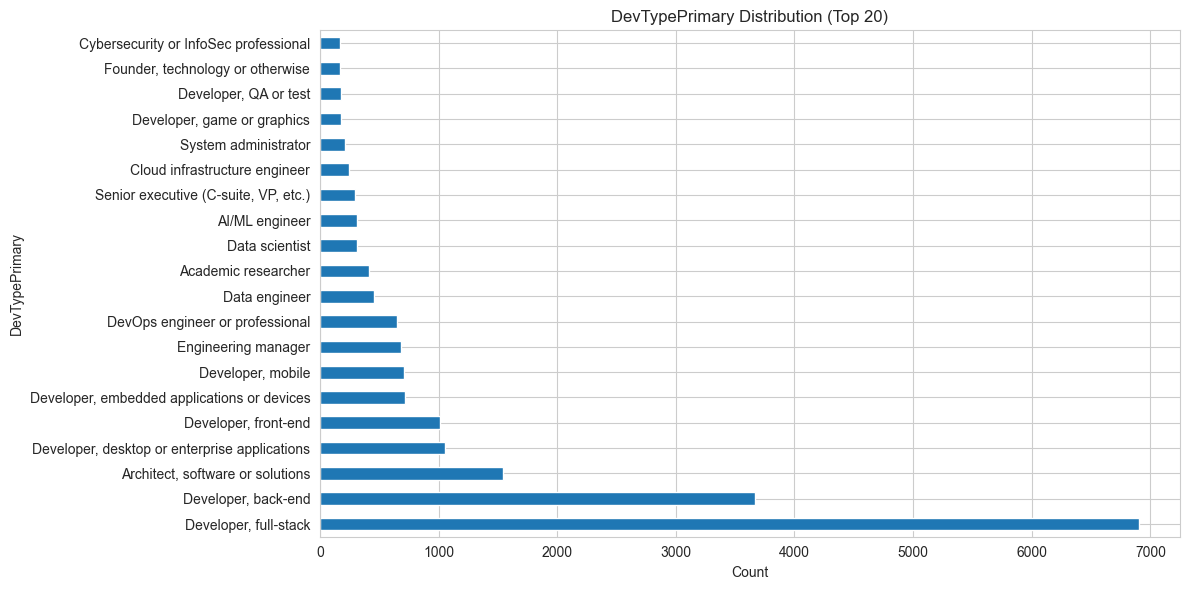


RemoteCategory Distribution:
                 Count  Percentage
RemoteCategory                    
Remote            6574       31.44
Hybrid-InPerson   3836       18.35
Hybrid-Flexible   3545       16.96
In-person         2653       12.69
Hybrid-Choice     2489       11.91

Imbalance Metrics:
  Most common: Remote (31.44%)
  Least common: Hybrid-Choice (11.91%)
  Imbalance ratio: 2.64x
  ✓ Relatively balanced


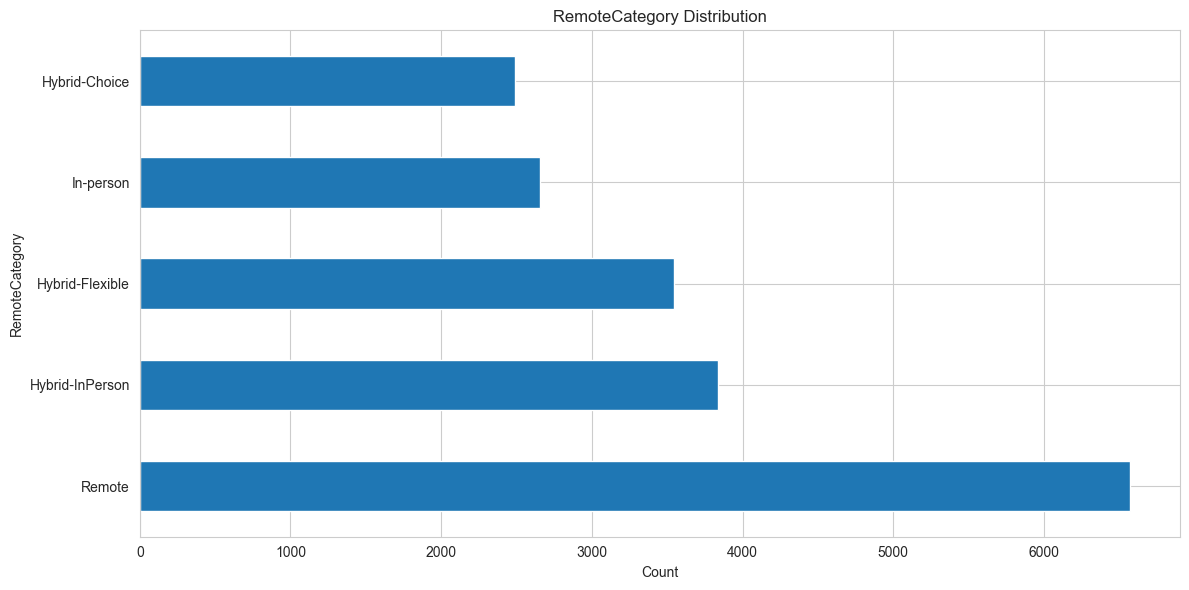


Employment Distribution:
                                                    Count  Percentage
Employment                                                           
Employed                                            18142       86.77
Independent contractor, freelancer, or self-emp...   2765       13.23

Imbalance Metrics:
  Most common: Employed (86.77%)
  Least common: Independent contractor, freelancer, or self-employed (13.23%)
  Imbalance ratio: 6.56x
  ✓ Relatively balanced


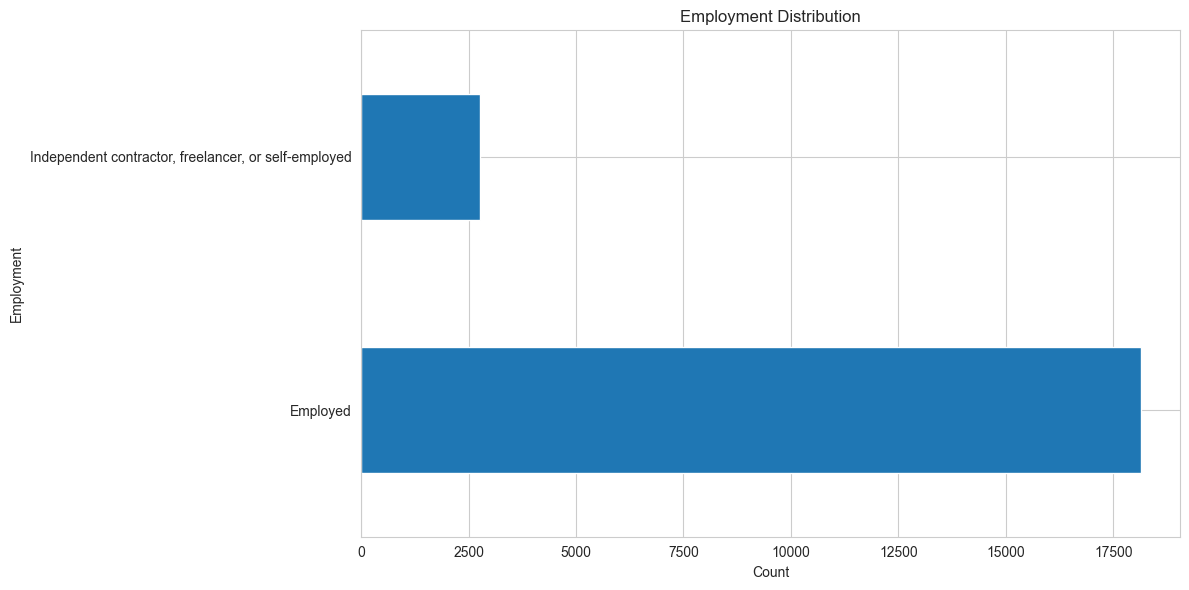

In [10]:
# Analyze categorical feature distributions for imbalance
categorical_features = ['Country', 'EdLevelSimplified', 'DevTypePrimary', 'RemoteCategory', 'Employment']

for col in categorical_features:
    if col in df_clean.columns:
        print(f"\n{'='*60}")
        print(f"{col} Distribution:")
        print('='*60)
        value_counts = df_clean[col].value_counts()
        percentages = (value_counts / len(df_clean) * 100).round(2)
        
        dist_df = pd.DataFrame({
            'Count': value_counts,
            'Percentage': percentages
        })
        print(dist_df)
        
        # Calculate imbalance metrics
        max_pct = percentages.max()
        min_pct = percentages.min()
        imbalance_ratio = max_pct / min_pct if min_pct > 0 else float('inf')
        
        print(f"\nImbalance Metrics:")
        print(f"  Most common: {value_counts.index[0]} ({max_pct}%)")
        print(f"  Least common: {value_counts.index[-1]} ({min_pct}%)")
        print(f"  Imbalance ratio: {imbalance_ratio:.2f}x")
        print(f"  {'⚠️ Significant imbalance' if imbalance_ratio > 10 else '✓ Relatively balanced'}")
        
        # Visualize
        plt.figure(figsize=(12, 6))
        if len(value_counts) > 20:
            # Show top 20
            top_20 = value_counts.head(20)
            top_20.plot(kind='barh')
            plt.title(f'{col} Distribution (Top 20)')
        else:
            value_counts.plot(kind='barh')
            plt.title(f'{col} Distribution')
        plt.xlabel('Count')
        plt.tight_layout()
        plt.show()


Salary Distribution by Bins (for Stratification):
           Count  Percentage
SalaryBin                   
0           2101       10.05
1           2092       10.01
2           2093       10.01
3           2078        9.94
4           2090       10.00
5           2096       10.03
6           2113       10.11
7           2110       10.09
8           2056        9.83
9           2078        9.94


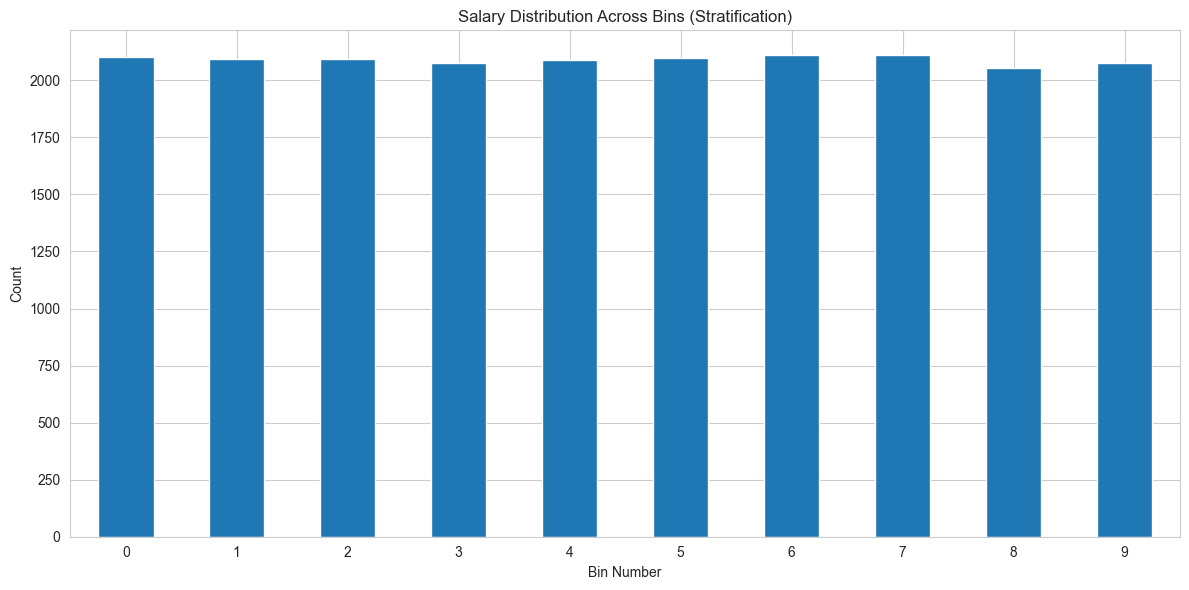


Bin Balance Metrics:
  Min bin size: 9.83%
  Max bin size: 10.11%
  Balance ratio: 1.03x
  ✓ Bins are well balanced


In [11]:
# Salary distribution binned for stratification analysis
n_bins = 10
df_clean['SalaryBin'] = pd.qcut(df_clean[target_col], q=n_bins, labels=False, duplicates='drop')

print("Salary Distribution by Bins (for Stratification):")
bin_counts = df_clean['SalaryBin'].value_counts().sort_index()
bin_pct = (bin_counts / len(df_clean) * 100).round(2)

bin_df = pd.DataFrame({
    'Count': bin_counts,
    'Percentage': bin_pct
})
print(bin_df)

# Visualize bin distribution
plt.figure(figsize=(12, 6))
bin_counts.sort_index().plot(kind='bar')
plt.title('Salary Distribution Across Bins (Stratification)')
plt.xlabel('Bin Number')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Check bin balance
min_bin_pct = bin_pct.min()
max_bin_pct = bin_pct.max()
balance_ratio = max_bin_pct / min_bin_pct if min_bin_pct > 0 else float('inf')

print(f"\nBin Balance Metrics:")
print(f"  Min bin size: {min_bin_pct}%")
print(f"  Max bin size: {max_bin_pct}%")
print(f"  Balance ratio: {balance_ratio:.2f}x")
print(f"  {'⚠️ Some bins are very small' if balance_ratio > 2 else '✓ Bins are well balanced'}")


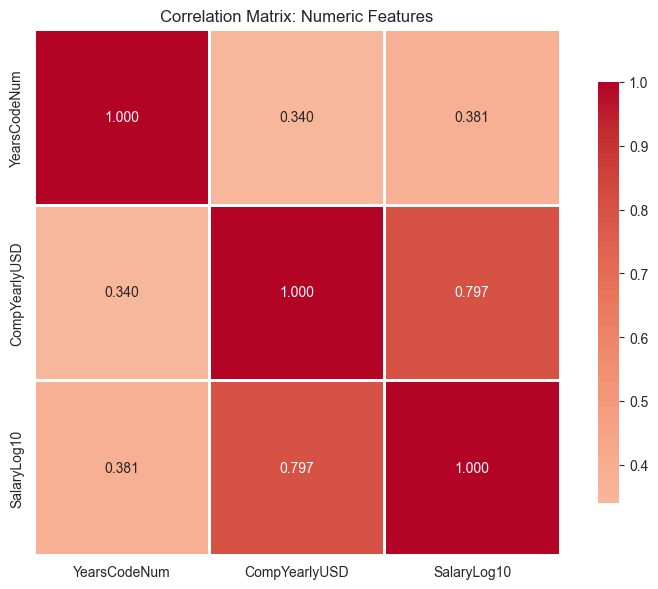

Correlation with Target (CompYearlyUSD):
CompYearlyUSD    1.000000
SalaryLog10      0.797098
YearsCodeNum     0.340398
Name: CompYearlyUSD, dtype: float64


In [12]:
# Feature correlation analysis (for numeric features)
numeric_features = ['YearsCodeNum', 'CompYearlyUSD', 'SalaryLog10']

corr_matrix = df_clean[numeric_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Numeric Features')
plt.tight_layout()
plt.show()

print("Correlation with Target (CompYearlyUSD):")
correlations = df_clean[numeric_features].corr()['CompYearlyUSD'].sort_values(ascending=False)
print(correlations)


In [13]:
# Summary statistics for processed features
print("Processed Dataset Summary:")
print(f"  Total features: {df_processed.shape[1] - 1}")  # Exclude target
print(f"  Total samples: {len(df_processed):,}")

# Check feature types
feature_cols = [col for col in df_processed.columns if col != 'CompYearlyUSD']
binary_features = [col for col in feature_cols if df_processed[col].nunique() == 2]
numeric_features = [col for col in feature_cols if col not in binary_features]

print(f"\nFeature Types:")
print(f"  Binary/One-hot encoded: {len(binary_features)}")
print(f"  Numeric: {len(numeric_features)}")

print(f"\nSample binary features: {binary_features[:5]}")
print(f"\nNumeric features: {numeric_features}")


Processed Dataset Summary:
  Total features: 193
  Total samples: 20,907

Feature Types:
  Binary/One-hot encoded: 192
  Numeric: 1

Sample binary features: ['Country_Albania', 'Country_Algeria', 'Country_Andorra', 'Country_Angola', 'Country_Argentina']

Numeric features: ['YearsCodeNum']


## Summary of Findings


In [14]:
# Final summary
print("="*60)
print("DATA PREPARATION SUMMARY")
print("="*60)

print(f"\n1. Data Reduction:")
print(f"   Raw dataset: {len(df_raw):,} rows")
print(f"   Clean dataset: {len(df_clean):,} rows")
print(f"   Reduction: {(1 - len(df_clean)/len(df_raw))*100:.1f}%")

print(f"\n2. Train/Test Split:")
print(f"   Train: {len(df_train):,} samples ({len(df_train)/(len(df_train)+len(df_test))*100:.1f}%)")
print(f"   Test: {len(df_test):,} samples ({len(df_test)/(len(df_train)+len(df_test))*100:.1f}%)")
print(f"   Stratified: ✓ Yes (by salary bins)")

print(f"\n3. Target Variable:")
print(f"   Mean: ${df_clean[target_col].mean():,.0f}")
print(f"   Median: ${df_clean[target_col].median():,.0f}")
print(f"   Std Dev: ${df_clean[target_col].std():,.0f}")
print(f"   Range: ${df_clean[target_col].min():,.0f} - ${df_clean[target_col].max():,.0f}")

print(f"\n4. Features:")
print(f"   Total encoded features: {len(feature_cols)}")
print(f"   Categorical (one-hot): {len(binary_features)}")
print(f"   Numeric: {len(numeric_features)}")

print(f"\n5. Data Quality:")
print(f"   Missing values in clean data: {df_clean.isna().sum().sum()}")
print(f"   Missing values in processed data: {df_processed.isna().sum().sum()}")

print("\n✅ Dataset is ready for modeling!")
print("="*60)


DATA PREPARATION SUMMARY

1. Data Reduction:
   Raw dataset: 49,123 rows
   Clean dataset: 20,907 rows
   Reduction: 57.4%

2. Train/Test Split:
   Train: 16,725 samples (80.0%)
   Test: 4,182 samples (20.0%)
   Stratified: ✓ Yes (by salary bins)

3. Target Variable:
   Mean: $95,070
   Median: $80,050
   Std Dev: $75,393
   Range: $1,000 - $600,000

4. Features:
   Total encoded features: 193
   Categorical (one-hot): 192
   Numeric: 1

5. Data Quality:
   Missing values in clean data: 1810
   Missing values in processed data: 0

✅ Dataset is ready for modeling!
